In [1]:
import mujoco
import mediapy as media
import numpy as np

%env MUJOCO_GL=egl 
renderer = None

env: MUJOCO_GL=egl


In [2]:
%%capture
!pip3 install robot_descriptions

In [3]:
from robot_descriptions import ur5e_mj_description

### General Usage and Rendering

Importing the model in xml format:

In [4]:
model = mujoco.MjModel.from_xml_path(ur5e_mj_description.MJCF_PATH)
data = mujoco.MjData(model)


In [5]:
if renderer is None:
    renderer = mujoco.Renderer(model)#, width=800, height=600)

In [6]:
mujoco.mj_resetData(model, data)  # Reset state and time.
mujoco.mj_step(model, data)

#### Model `mjModel` 

MuJoCo's model is given by instance `mjModel` and contains the *model description*, i.e., all quantities which *do not change over time*. 

The complete description of `mjModel` can be found at the end of the header file [`mjmodel.h`](https://github.com/deepmind/mujoco/blob/main/include/mujoco/mjmodel.h). Note that the header files contain short, useful inline comments, describing each field.

Examples of quantities that can be found in `mjModel` are `ngeom`, the number of geoms in the scene and `geom_rgba`, their respective colors:

In [7]:
nbody = model.nbody
nv = model.nv
nq = model.nq

In [8]:
print('Total number of DoFs in the model:', model.nv)
print('Total number of coordinates:', model.nq)

Total number of DoFs in the model: 6
Total number of coordinates: 6


Each body have atributes...

In [9]:
[model.body(i).name for i in range(model.nbody)]

['world',
 'base',
 'shoulder_link',
 'upper_arm_link',
 'forearm_link',
 'wrist_1_link',
 'wrist_2_link',
 'wrist_3_link']

In [10]:
model.body('upper_arm_link') # model.body(3)

<_MjModelBodyViews
  dofadr: array([1], dtype=int32)
  dofnum: array([1], dtype=int32)
  geomadr: array([6], dtype=int32)
  geomnum: array([6], dtype=int32)
  id: 3
  inertia: array([0.133886 , 0.133886 , 0.0151074])
  invweight0: array([0.01906809, 0.38203231])
  ipos: array([0.    , 0.    , 0.2125])
  iquat: array([1., 0., 0., 0.])
  jntadr: array([1], dtype=int32)
  jntnum: array([1], dtype=int32)
  mass: array([8.393])
  mocapid: array([-1], dtype=int32)
  name: 'upper_arm_link'
  parentid: array([2], dtype=int32)
  pos: array([0.   , 0.138, 0.   ])
  quat: array([0.70710678, 0.        , 0.70710678, 0.        ])
  rootid: array([1], dtype=int32)
  sameframe: array([0], dtype=uint8)
  simple: array([0], dtype=uint8)
  subtreemass: array([13.2949])
  user: array([], dtype=float64)
  weldid: array([3], dtype=int32)
>

The velocities are easy to interpret, 6 zeros, one for each DoF. What about the length 7 positions? We can see the initial 2cm height of the body; the subsequent four numbers are the 3D orientation, defined by a *unit quaternion*. 3D orientations are represented with **4** numbers while angular velocities are **3** numbers. For more information see the Wikipedia article on [quaternions and spatial rotation](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation).


#### Data `mjData`
The `mjData` structure contains the dynamic variables and intermediate results produced by the simulation which are *expected to change* on each timestep. 



In [11]:
print(f'time in simulator {data.time}')

time in simulator 0.002


In [12]:
print(f'coordinates:\n {data.qpos}')

coordinates:
 [-2.18793406e-07  6.07067749e-05 -1.24037658e-05 -6.21862143e-06
  4.50999635e-07 -4.27317859e-08]


In [13]:
print(f'positions:\n {data.xpos}')


positions:
 [[ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.163]
 [-0.138  0.     0.163]
 [-0.007  0.425  0.163]
 [-0.007  0.817  0.163]
 [-0.134  0.817  0.163]
 [-0.134  0.817  0.063]]


In [14]:
data.qpos = np.random.randn(6) 
mujoco.mj_kinematics(model, data)
print(f'positions:\n {data.xpos}')

positions:
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.163     ]
 [-0.10343171  0.0913558   0.163     ]
 [-0.04295332 -0.03805709  0.58416585]
 [-0.27576695 -0.3016453   0.75732205]
 [-0.3709541  -0.21757149  0.75732205]
 [-0.30631226 -0.14438494  0.77888966]]


#### Options `mjOptions`
This is the data structure with simulation options. It corresponds to the MJCF element option. One instance of it is embedded in mjModel.

In [15]:
model.opt

<MjOption
  apirate: 100.0
  cone: 0
  density: 0.0
  disableactuator: 0
  disableflags: 0
  enableflags: 0
  gravity: array([ 0.  ,  0.  , -9.81])
  impratio: 1.0
  integrator: 0
  iterations: 100
  jacobian: 2
  ls_iterations: 50
  ls_tolerance: 0.01
  magnetic: array([ 0. , -0.5,  0. ])
  mpr_iterations: 50
  mpr_tolerance: 1e-06
  noslip_iterations: 0
  noslip_tolerance: 1e-06
  o_friction: array([1.e+00, 1.e+00, 5.e-03, 1.e-04, 1.e-04])
  o_margin: 0.0
  o_solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  o_solref: array([0.02, 1.  ])
  sdf_initpoints: 40
  sdf_iterations: 10
  solver: 2
  timestep: 0.002
  tolerance: 1e-08
  viscosity: 0.0
  wind: array([0., 0., 0.])
>

#### Rendering

In order to render we'll need to instantiate a `Renderer` object and call its `render` method.

""

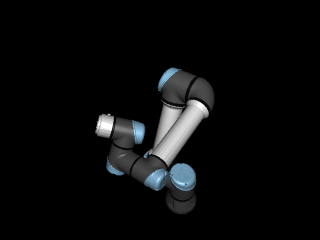

In [16]:
q0 = np.array([-0.6,-1.2,-2.1,0.7,0.7,0.7])
data.qpos = q0 
mujoco.mj_kinematics(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

Short video

In [17]:
timespan = np.linspace(0, 2, 500)
# print(timespan)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

for time in timespan:
    data.qpos[0] = -3+2*np.sin(time)
    mujoco.mj_kinematics(model, data)
    if len(frames) < time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

In [18]:
media.show_video(frames, fps=framerate)

### Kinematics

In [19]:
mujoco.mj_resetData(model, data)  # Reset state and time.

In [20]:
data.qpos = np.array([-0.6,-1.2,-2.1,0.7,0.7,0.7])
mujoco.mj_kinematics(model, data)


#### Forward kinematics

In [21]:
print(f'positions:\n {data.xpos}')

positions:
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.163     ]
 [-0.11389631  0.07792066  0.163     ]
 [ 0.08117875  0.13105587  0.55911661]
 [-0.13738988 -0.188425    0.4972803 ]
 [-0.2422075  -0.11671541  0.4972803 ]
 [-0.2131001  -0.07416924  0.58296917]]


In [22]:
print(f'quaternions of body frames:\n {data.xquat}')  

quaternions of body frames:
 [[ 1.          0.          0.          0.        ]
 [ 0.70710678  0.          0.          0.70710678]
 [ 0.88448925  0.          0.          0.46656057]
 [ 0.8693317  -0.08600479  0.16304488  0.45856509]
 [ 0.5739832   0.35497651 -0.67295209  0.30277126]
 [ 0.85225686 -0.12480441  0.23659984  0.44955825]
 [ 0.6464343  -0.03610829  0.26505059  0.71453976]
 [ 0.51635747 -0.27893326  0.47064219  0.6588377 ]]


In [23]:
print(f'rotation matrices of body frames:\n {data.xmat}') 


rotation matrices of body frames:
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [ 5.64642473e-01 -8.25335615e-01  0.00000000e+00  8.25335615e-01
   5.64642473e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [ 5.26268855e-01 -8.25335615e-01  2.04602579e-01  7.69245052e-01
   5.64642473e-01  2.99066760e-01 -3.62357754e-01  0.00000000e+00
   9.32039086e-01]
 [-8.90699189e-02 -8.25335615e-01 -5.57573020e-01 -1.30193139e-01
   5.64642473e-01 -8.15002223e-01  9.87479770e-01 -5.55111512e-17
  -1.57745694e-01]
 [ 4.83835785e-01 -8.25335615e-01  2.91073970e-01  7.07220806e-01
   5.64642473e-01  4.25461642e-01 -5.15501372e-01 -5.55111512e-17
   8.56888753e-01]
 [-1.61637781e-01 -9.42947067e-01  2.91073970e-01  9.046649

In [24]:
print(f'positions of body COMs :\n {data.xipos}')  
print(f'orientations aligned with inertia:\n {data.ximat}')   
print(f'positions:\n {data.xanchor}')  
print(f'positions:\n {data.xaxis}') 

positions of body COMs :
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.163     ]
 [-0.07041827  0.14147235  0.36105831]
 [-0.02810557 -0.02868457  0.52819846]
 [-0.2422075  -0.11671541  0.4972803 ]
 [-0.2131001  -0.07416924  0.58296917]
 [-0.28586573 -0.07600135  0.60859639]]
orientations aligned with inertia:
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [ 5.64642473e-01 -8.25335615e-01  0.00000000e+00  8.25335615e-01
   5.64642473e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [ 5.26268855e-01 -8.25335615e-01  2.04602579e-01  7.69245052e-01
   5.64642473e-01  2.99066760e-01 -3.62357754e-01  0.00000000e+00
   9.32039086e-01]
 [-8.90699189e-02 -8.

#### Jacobians

In [25]:
jacp = np.zeros((3, model.nv))
jacr = np.zeros((3, model.nv))
point = np.zeros(3)

mujoco.mj_step(model, data)
mujoco.mj_jac(model, data, jacp, jacr, point, 2)

In [26]:
mujoco.mj_jacBody(model, data, jacp, jacr, 2)

In [27]:
jacp


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [28]:
jacr

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [29]:
data.qpos = np.array([-0.6,-1.2,-2.1,0.7,0.7,0.7])
jacp_body = np.zeros((model.nbody, 3, model.nv))
jacr_body = np.zeros((model.nbody, 3, model.nv))
mujoco.mj_step(model, data)
q = data.qpos.copy()
for body_id in range(model.nbody):
    mujoco.mj_jacBody(model, data, 
                      jacp_body[body_id], 
                      jacr_body[body_id], body_id)


#### Velocities

In [30]:
vel_world = np.zeros((model.nbody, 3))
omega_body = np.zeros((model.nbody, 3))

dq = 20*np.ones(model.nv)

for body_id in range(model.nbody):
    vel_world[body_id,:] = jacp_body[body_id]@dq
    omega_body[body_id,:] = jacr_body[body_id]@dq

In [31]:
omega_body

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  20.        ],
       [-16.5067123 ,  11.29284947,  20.        ],
       [-33.0134246 ,  22.58569894,  20.        ],
       [-49.52013689,  33.8785484 ,  20.        ],
       [-43.6986575 ,  42.38778124,  37.13777507],
       [-62.55759885,  41.91294588,  43.7796771 ]])

In [32]:
vel_world

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-1.55841323, -2.2779263 ,  0.        ],
       [ 1.85216786,  8.16215788, -3.08004091],
       [ 6.84516896,  1.74935697, 12.40364188],
       [ 5.41097708, -0.34699549, 12.40364188],
       [ 7.4630685 ,  4.47847729,  9.31063365]])

In [33]:
omega_body

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  20.        ],
       [-16.5067123 ,  11.29284947,  20.        ],
       [-33.0134246 ,  22.58569894,  20.        ],
       [-49.52013689,  33.8785484 ,  20.        ],
       [-43.6986575 ,  42.38778124,  37.13777507],
       [-62.55759885,  41.91294588,  43.7796771 ]])

### Dynamics

Inverse dynamics, 

In [34]:
data.qpos = q0
data.qvel = np.random.randn(nv)
data.qacc = np.random.randn(nv)
mujoco.mj_inverse(model, data)
combined_force = data.qfrc_inverse.copy()
combined_force

array([-387.34058198, -118.85988198,  -79.81934978,   23.16827443,
         15.4949897 ,   18.41422495])

""

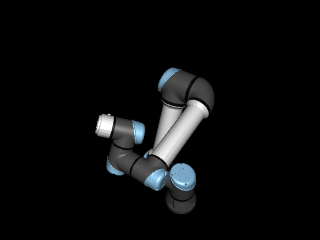

In [35]:

renderer.update_scene(data)
media.show_image(renderer.render())

In [36]:
data.qvel = np.zeros(6)
data.qacc = np.zeros(6)
mujoco.mj_inverse(model, data)
gravity_force = data.qfrc_inverse.copy()
gravity_force

array([ 0.00000000e+00, -8.37124023e-02,  1.36617870e+01, -6.33044693e-01,
        5.63821404e-02,  8.32667268e-17])

**Inertia matrix**:

In [37]:
data.qM

array([ 5.52531505e-01,  1.46089032e+00, -3.74656125e-01,  5.76542768e-01,
        2.19572498e-01,  4.90113869e-03,  1.19784066e-01, -1.29545635e-02,
        4.66889158e-02, -1.80473231e-02,  1.03418176e-01, -1.11491748e-03,
        1.70062080e-03, -2.96883351e-03,  5.91398753e-03,  1.00132134e-01,
        1.23908431e-18,  1.01061658e-04,  1.01061658e-04,  1.01061658e-04,
        4.38810541e-05])

In [38]:
inertia_matrix = np.zeros((nv,nv))
mujoco.mj_fullM(model, inertia_matrix, data.qM )

In [39]:
inertia_matrix

array([[ 5.52531505e-01, -3.74656125e-01,  4.90113869e-03,
        -1.80473231e-02,  5.91398753e-03,  4.38810541e-05],
       [-3.74656125e-01,  1.46089032e+00,  2.19572498e-01,
         4.66889158e-02, -2.96883351e-03,  1.01061658e-04],
       [ 4.90113869e-03,  2.19572498e-01,  5.76542768e-01,
        -1.29545635e-02,  1.70062080e-03,  1.01061658e-04],
       [-1.80473231e-02,  4.66889158e-02, -1.29545635e-02,
         1.19784066e-01, -1.11491748e-03,  1.01061658e-04],
       [ 5.91398753e-03, -2.96883351e-03,  1.70062080e-03,
        -1.11491748e-03,  1.03418176e-01,  1.23908431e-18],
       [ 4.38810541e-05,  1.01061658e-04,  1.01061658e-04,
         1.01061658e-04,  1.23908431e-18,  1.00132134e-01]])

### Simulation

| Integrator                           | Mujoco flag| 
|---|---|
| Semi-implicit Euler                            | `mujoco.mjtIntegratormjINT_EULER`| 
| 4th-order Runge Kutta                          | `mujoco.mjtIntegratormjINT_RK4`|
| Euler implicit in velocity                     | `mujoco.mjtIntegratormjINT_IMPLICIT`|
| Implicit in velocity Euler, no coriolis terms  | `mujoco.mjINT_IMPLICITFAST`|

In [40]:
model.opt.integrator = mujoco.mjtIntegrator.mjINT_IMPLICIT

In [41]:
model.opt.timestep = 0.001# reduce integrator time

In [42]:
duration = 4  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.qpos = np.array([-0.6,-1.2,-2.1,0.7,0.7,0.7])

while data.time < duration:
  data.ctrl = np.array([0, 0, 0, 0, 0, 0])
  mujoco.mj_step(model, data)
  # print(data.time, data.qpos, data.qvel)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

### Control

Setting actuator types:

In [43]:

class ActuatorMotor:
    def __init__(self, torque_range = [-100,100]) -> None:
        self.range = torque_range
        self.dyn = np.array([1, 0, 0])
        self.gain = np.array([1, 0, 0])
        self.bias = np.array([0, 0, 0])

    def __repr__(self) -> str:
        return f"ActuatorMotor(dyn={self.dyn}, gain={self.gain}, bias={self.bias})"


class ActuatorPosition(ActuatorMotor):
    def __init__(self, kp=1, kd=0, position_range = [-100,100]) -> None:
        super().__init__()
        self.range = position_range
        self.kp = kp
        self.kd = kd
        self.gain[0] = self.kp
        self.bias[1] = -self.kp
        self.bias[2] = -self.kd


class ActuatorVelocity(ActuatorMotor):
    def __init__(self, kv=1,  velocity_range = [-100,100]) -> None:
        super().__init__()
        self.range = velocity_range
        self.kv = kv
        self.gain[0] = self.kv
        self.bias[2] = -self.kv

def update_actuator(model, actuator_id, actuator):
    """
    Update actuator in model
    model - mujoco.MjModel
    actuator_id - int or str (name) (for reference see, named access to model elements)
    actuator - ActuatorMotor, ActuatorPosition, ActuatorVelocity
    """
    model.actuator(actuator_id).dynprm = np.zeros(len(model.actuator(actuator_id).dynprm))
    model.actuator(actuator_id).gainprm = np.zeros(len(model.actuator(actuator_id).gainprm))
    model.actuator(actuator_id).biasprm = np.zeros(len(model.actuator(actuator_id).biasprm))
    model.actuator(actuator_id).ctrlrange = actuator.range 
    model.actuator(actuator_id).dynprm[:3] = actuator.dyn
    model.actuator(actuator_id).gainprm[:3] = actuator.gain
    model.actuator(actuator_id).biasprm[:3] = actuator.bias

In [52]:
# update actuators
position_motor = ActuatorPosition(kp=200, kd=100)

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, position_motor)

# setup simulation
q_des = np.array([-0.6,-1.2,-2.1,0.7,0.7,0.7])

duration = 5  # (seconds)
framerate = 30  # (Hz)
n_steps = int(np.ceil(duration * framerate)) + 1

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.

history_q = []

while data.time < duration:
    data.ctrl[:] = q_des

    mujoco.mj_step(model, data)

    history_q.append(data.qpos.copy())

#     if len(frames) < data.time * framerate:
#         renderer.update_scene(data, scene_option=dict())
#         pixels = renderer.render()
#         frames.append(pixels)

# media.show_video(frames, fps=framerate)

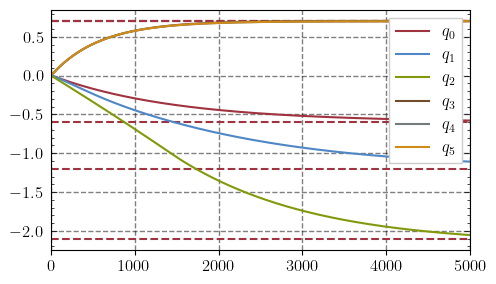

In [53]:
import matplotlib.pyplot as plt

history_q = np.array(history_q)

plt.hlines(q_des, 0, len(history_q), linestyles="dashed")
plt.plot(history_q, label=[fr"$q_{i}$" for i in range(6)])
plt.grid()
plt.legend()
plt.show()

Torque Based Control:

In [46]:
# mujoco.mj_reset(model, data)

# setup simulation
q0 = np.array([-3.6,-1.2,-2.1,0.7,0.7,0.7])
q_des = np.array([-2.6,-0.8,-1.9,0.7,0.7,0.7])


mujoco.mj_resetData(model, data)  # Reset state and time.
data.qpos = q0
data.qvel = np.zeros(model.nv)
# set up actuators
torque_motor = ActuatorMotor()

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, torque_motor)

duration = 2.3  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
history_q = []
while data.time < duration:
    q = data.qpos.copy()
    dq = data.qvel.copy()
    history_q.append(q)

    # Do your control here!
    # data.qpos, data.qvel 
    # i.e: PD control:
    data.ctrl[:] = 250.*(q_des - q) - 50.*dq #np.zeros(model.nu)
    # data.ctrl[:] = np.zeros(model.nu)
    mujoco.mj_step(model, data)
    
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
        
media.show_video(frames, fps=framerate)

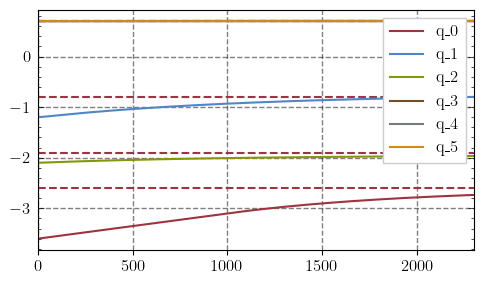

In [49]:

history_q = np.array(history_q)

plt.hlines(q_des, 0, len(history_q), linestyles="dashed")
plt.plot(history_q, label=["q_" + str(i) for i in range( 6)])
plt.grid()
plt.legend()
plt.show()